Запуск бэктестирования ROC Momentum Strategy...
Загрузка данных BTCUSDT с 2025-01-01 по 2025-06-08...
Загружено 334 свечей, всего: 334
Загружено 334 свечей, всего: 668
Загружено 334 свечей, всего: 1002
Загружено 334 свечей, всего: 1336
Загружено 334 свечей, всего: 1670
Загружено 334 свечей, всего: 2004
Загружено 334 свечей, всего: 2338
Загружено 334 свечей, всего: 2672
Загружено 334 свечей, всего: 3006
Загружено 334 свечей, всего: 3340
Загружено 334 свечей, всего: 3674
Загружено 334 свечей, всего: 4008
Загружено 334 свечей, всего: 4342
Загружено 334 свечей, всего: 4676
Загружено 334 свечей, всего: 5010
Загружено 334 свечей, всего: 5344
Загружено 334 свечей, всего: 5678
Загружено 334 свечей, всего: 6012
Загружено 334 свечей, всего: 6346
Загружено 334 свечей, всего: 6680
Загружено 334 свечей, всего: 7014
Загружено 334 свечей, всего: 7348
Загружено 334 свечей, всего: 7682
Загружено 334 свечей, всего: 8016
Загружено 334 свечей, всего: 8350
Загружено 334 свечей, всего: 8684
Загружено 334 св

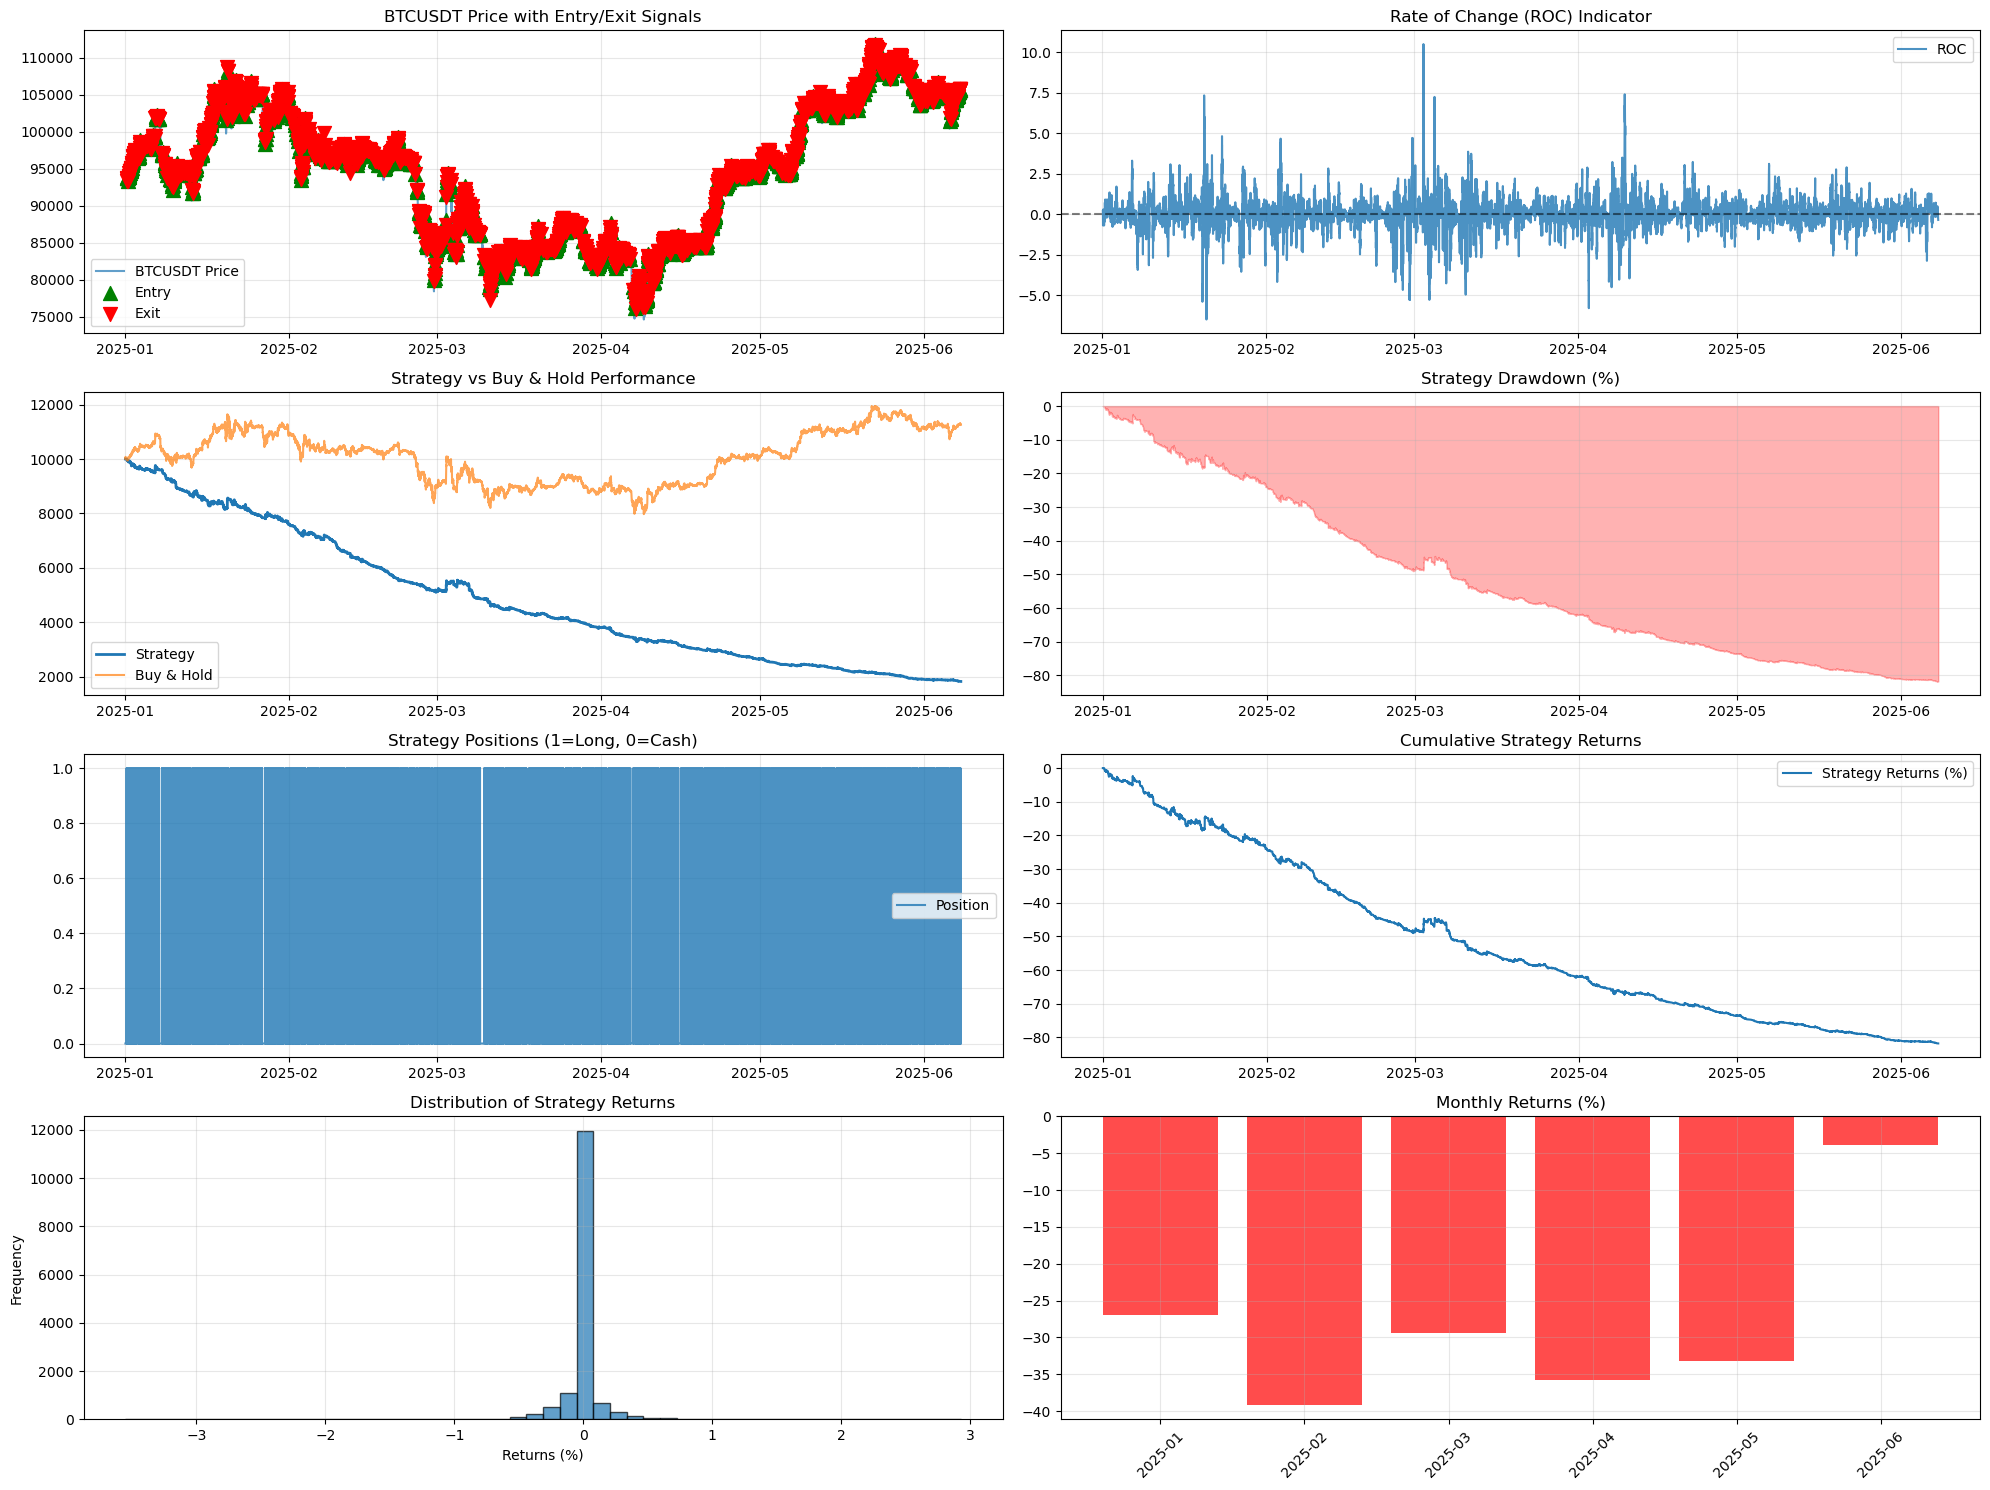


РЕЗУЛЬТАТЫ БЭКТЕСТИРОВАНИЯ ROC MOMENTUM STRATEGY
Период тестирования: 2025-01-01 - 2025-06-08
Актив: BTCUSDT
Таймфрейм: 15m
Начальный капитал: $10,000.00
------------------------------------------------------------
Общая доходность стратегии: -81.78%
Доходность Buy & Hold: 12.57%
Превышение над рынком: -94.35%
Максимальная просадка: -81.79%
Коэффициент Шарпа: -1.243
------------------------------------------------------------
Общее количество сделок: 4988
Процент прибыльных сделок: 37.9%
Средняя прибыльная сделка: 0.190%
Средняя убыточная сделка: -0.107%
Profit Factor: 1.78
------------------------------------------------------------
Итоговый капитал: $1,822.44
Общая прибыль: $-8,177.56

Результаты сохранены в файл 'roc_momentum_backtest_results.csv'


In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ========== НАСТРОЙКИ СТРАТЕГИИ ==========
SYMBOL = 'BTCUSDT'
INTERVAL = '15m'
START_DATE = '2025-01-01'
END_DATE = '2025-06-08'
INITIAL_CAPITAL = 10000  # USD
ROC_PERIOD = 14  # Период для расчета ROC
COMMISSION = 0.00035  # 0.1% комиссия
MIN_TRADE_SIZE = 10  # Минимальный размер сделки в USD

# API настройки Binance
BINANCE_API_URL = 'https://fapi.binance.com'

# ========== ФУНКЦИИ ДЛЯ ПОЛУЧЕНИЯ ДАННЫХ ==========
def get_binance_klines(symbol, interval, start_str, end_str):
    """Получение данных с Binance Futures API"""
    url = f"{BINANCE_API_URL}/fapi/v1/klines"
    
    # Конвертируем даты в timestamp
    start_timestamp = int(pd.to_datetime(start_str).timestamp() * 1000)
    end_timestamp = int(pd.to_datetime(end_str).timestamp() * 1000)
    
    all_data = []
    current_start = start_timestamp
    
    while current_start < end_timestamp:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': min(current_start + 1000 * 300000, end_timestamp),  # Максимум 1000 свечей за раз
            'limit': 1000
        }
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if not data:
                break
                
            all_data.extend(data)
            current_start = data[-1][6] + 1  # Время закрытия последней свечи + 1мс
            
            print(f"Загружено {len(data)} свечей, всего: {len(all_data)}")
            
        except Exception as e:
            print(f"Ошибка при получении данных: {e}")
            break
    
    if not all_data:
        raise ValueError("Не удалось получить данные")
    
    # Преобразуем в DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Конвертируем типы данных
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    return df[['open', 'high', 'low', 'close', 'volume']]

def calculate_roc(prices, period):
    """Расчет Rate of Change (ROC)"""
    return ((prices - prices.shift(period)) / prices.shift(period)) * 100

def momentum_roc_strategy(df):
    """Реализация стратегии Momentum ROC"""
    
    # Расчет ROC
    df['roc'] = calculate_roc(df['close'], ROC_PERIOD)
    df['roc_prev'] = df['roc'].shift(1)
    
    # Условия входа и выхода
    df['entry_signal'] = (df['roc'] > 0) & (df['roc'] > df['roc_prev'])
    df['exit_signal'] = (df['roc'] < 0) | (df['roc'] < df['roc_prev'])
    
    # Генерация сигналов
    df['position'] = 0
    df['signal'] = 0
    
    in_position = False
    
    for i in range(1, len(df)):
        if not in_position and df['entry_signal'].iloc[i]:
            df.loc[df.index[i], 'signal'] = 1  # Покупка
            in_position = True
        elif in_position and df['exit_signal'].iloc[i]:
            df.loc[df.index[i], 'signal'] = -1  # Продажа
            in_position = False
        
        # Устанавливаем позицию
        if df['signal'].iloc[i] == 1:
            df.loc[df.index[i]:, 'position'] = 1
        elif df['signal'].iloc[i] == -1:
            df.loc[df.index[i]:, 'position'] = 0
    
    return df

def backtest_strategy(df):
    """Бэктестирование стратегии"""
    
    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['position'].shift(1) * df['returns']
    
    # Учет комиссий
    df['trades'] = df['signal'].abs()
    df['commission_cost'] = df['trades'] * COMMISSION
    df['net_strategy_returns'] = df['strategy_returns'] - df['commission_cost']
    
    # Расчет капитала
    df['capital'] = INITIAL_CAPITAL * (1 + df['net_strategy_returns']).cumprod()
    df['benchmark'] = INITIAL_CAPITAL * (1 + df['returns']).cumprod()
    
    return df

def calculate_metrics(df):
    """Расчет метрик производительности"""
    
    # Основные метрики
    total_return = (df['capital'].iloc[-1] / INITIAL_CAPITAL - 1) * 100
    benchmark_return = (df['benchmark'].iloc[-1] / INITIAL_CAPITAL - 1) * 100
    
    # Количество сделок
    total_trades = df['trades'].sum()
    
    # Drawdown
    rolling_max = df['capital'].expanding().max()
    drawdown = (df['capital'] - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    # Sharpe ratio (аннуализированный)
    strategy_sharpe = df['net_strategy_returns'].mean() / df['net_strategy_returns'].std() * np.sqrt(288)  # 288 = 5min периодов в дне
    
    # Win rate
    winning_trades = df[df['net_strategy_returns'] > 0]['net_strategy_returns'].count()
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    
    # Средняя прибыль/убыток
    avg_win = df[df['net_strategy_returns'] > 0]['net_strategy_returns'].mean() * 100
    avg_loss = df[df['net_strategy_returns'] < 0]['net_strategy_returns'].mean() * 100
    
    return {
        'total_return': total_return,
        'benchmark_return': benchmark_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': strategy_sharpe,
        'total_trades': total_trades,
        'win_rate': win_rate,
        'avg_win': avg_win if not pd.isna(avg_win) else 0,
        'avg_loss': avg_loss if not pd.isna(avg_loss) else 0,
        'profit_factor': abs(avg_win / avg_loss) if avg_loss != 0 and not pd.isna(avg_loss) else 0
    }

def plot_results(df, metrics):
    """Построение графиков результатов"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. График цены и сигналов
    plt.subplot(4, 2, 1)
    plt.plot(df.index, df['close'], label='BTCUSDT Price', alpha=0.7)
    
    # Точки входа и выхода
    entry_points = df[df['signal'] == 1]
    exit_points = df[df['signal'] == -1]
    
    plt.scatter(entry_points.index, entry_points['close'], 
               color='green', marker='^', s=100, label='Entry', zorder=5)
    plt.scatter(exit_points.index, exit_points['close'], 
               color='red', marker='v', s=100, label='Exit', zorder=5)
    
    plt.title('BTCUSDT Price with Entry/Exit Signals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. ROC индикатор
    plt.subplot(4, 2, 2)
    plt.plot(df.index, df['roc'], label='ROC', alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Rate of Change (ROC) Indicator')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Сравнение доходности
    plt.subplot(4, 2, 3)
    plt.plot(df.index, df['capital'], label='Strategy', linewidth=2)
    plt.plot(df.index, df['benchmark'], label='Buy & Hold', alpha=0.7)
    plt.title('Strategy vs Buy & Hold Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Drawdown
    plt.subplot(4, 2, 4)
    rolling_max = df['capital'].expanding().max()
    drawdown = (df['capital'] - rolling_max) / rolling_max * 100
    plt.fill_between(df.index, drawdown, 0, color='red', alpha=0.3)
    plt.title('Strategy Drawdown (%)')
    plt.grid(True, alpha=0.3)
    
    # 5. Позиции
    plt.subplot(4, 2, 5)
    plt.plot(df.index, df['position'], label='Position', alpha=0.8)
    plt.title('Strategy Positions (1=Long, 0=Cash)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Кумулятивная доходность
    plt.subplot(4, 2, 6)
    cumulative_returns = (1 + df['net_strategy_returns']).cumprod() - 1
    plt.plot(df.index, cumulative_returns * 100, label='Strategy Returns (%)')
    plt.title('Cumulative Strategy Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Распределение доходности
    plt.subplot(4, 2, 7)
    plt.hist(df['net_strategy_returns'].dropna() * 100, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Strategy Returns')
    plt.xlabel('Returns (%)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # 8. Месячная доходность
    plt.subplot(4, 2, 8)
    monthly_returns = df['net_strategy_returns'].resample('M').sum() * 100
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    plt.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7)
    plt.title('Monthly Returns (%)')
    plt.xticks(range(len(monthly_returns)), [d.strftime('%Y-%m') for d in monthly_returns.index], rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Вывод метрик
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ БЭКТЕСТИРОВАНИЯ ROC MOMENTUM STRATEGY")
    print("="*60)
    print(f"Период тестирования: {START_DATE} - {END_DATE}")
    print(f"Актив: {SYMBOL}")
    print(f"Таймфрейм: {INTERVAL}")
    print(f"Начальный капитал: ${INITIAL_CAPITAL:,.2f}")
    print("-"*60)
    print(f"Общая доходность стратегии: {metrics['total_return']:.2f}%")
    print(f"Доходность Buy & Hold: {metrics['benchmark_return']:.2f}%")
    print(f"Превышение над рынком: {metrics['total_return'] - metrics['benchmark_return']:.2f}%")
    print(f"Максимальная просадка: {metrics['max_drawdown']:.2f}%")
    print(f"Коэффициент Шарпа: {metrics['sharpe_ratio']:.3f}")
    print("-"*60)
    print(f"Общее количество сделок: {int(metrics['total_trades'])}")
    print(f"Процент прибыльных сделок: {metrics['win_rate']:.1f}%")
    print(f"Средняя прибыльная сделка: {metrics['avg_win']:.3f}%")
    print(f"Средняя убыточная сделка: {metrics['avg_loss']:.3f}%")
    print(f"Profit Factor: {metrics['profit_factor']:.2f}")
    print("-"*60)
    print(f"Итоговый капитал: ${df['capital'].iloc[-1]:,.2f}")
    print(f"Общая прибыль: ${df['capital'].iloc[-1] - INITIAL_CAPITAL:,.2f}")
    print("="*60)

def main():
    """Основная функция"""
    print("Запуск бэктестирования ROC Momentum Strategy...")
    print(f"Загрузка данных {SYMBOL} с {START_DATE} по {END_DATE}...")
    
    try:
        # Получение данных
        df = get_binance_klines(SYMBOL, INTERVAL, START_DATE, END_DATE)
        print(f"Загружено {len(df)} свечей")
        
        # Применение стратегии
        df = momentum_roc_strategy(df)
        
        # Бэктестирование
        df = backtest_strategy(df)
        
        # Расчет метрик
        metrics = calculate_metrics(df)
        
        # Построение графиков и вывод результатов
        plot_results(df, metrics)
        
        # Сохранение результатов в CSV
        df.to_csv('roc_momentum_backtest_results.csv')
        print("\nРезультаты сохранены в файл 'roc_momentum_backtest_results.csv'")
        
    except Exception as e:
        print(f"Ошибка: {e}")
        print("Убедитесь в наличии интернет-соединения и корректности настроек")

if __name__ == "__main__":
    main()